# Convolutional Neural Network for Anime Image Classification

In [1]:
!pip install pandas==2.2.2
!pip install numpy==1.26.4
!pip install matplotlib==3.8.0
!pip install scikit-learn==1.5.0
!pip install torch==2.3.1
!pip install torchvision==0.18.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 3.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 5.2 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.1
    Uninstalling scikit-learn-1.5.1:
      Successfully uninstalled scikit-learn-1.5.1
  Using cached torch-2.3.1-cp311-none-macosx_11_0_arm64.whl.metadata (26 kB)
Using cached torch-2.3.1-cp311-none-macosx_11_0_arm64.whl (61.0 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.7.1
    Uninstalling torch-2.7.1:
      Successfully uninstalled torch-2.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
from PIL import Image

### Download the dataset: 
The dataset consists of 9,738 images across 130 character classes, with approximately 75 images per class, sourced from the Danbooru website—a platform developed by the Japanese animation-style cartoon community.



In [3]:
import io
import requests

def load_images_from_zip(zip_file):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        images = {'anastasia': [], 'takao': []}
        for file_name in zip_ref.namelist():
            if file_name.startswith('anastasia') and file_name.endswith('.jpg'):
                with zip_ref.open(file_name) as file:
                    img = Image.open(file).convert('RGB')
                    images['anastasia'].append(np.array(img))
            elif file_name.startswith('takao') and file_name.endswith('.jpg'):
                with zip_ref.open(file_name) as file:
                    img = Image.open(file).convert('RGB')
                    images['takao'].append(np.array(img))
    return images

zip_file_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/xZQHOyN8ONT92kH-ASb4Pw/data.zip'

# Download the ZIP file
response = requests.get(zip_file_url)
zip_file_bytes = io.BytesIO(response.content)

# Load images from zip file
images = load_images_from_zip(zip_file_bytes)

#### Check the number of images in each folder

In [7]:
print("Number of images of Anastasia:", len(images['anastasia']))
print("Number of images of Takao:", len(images['takao']))

Number of images of Anastasia: 50
Number of images of Takao: 50


### Let's visualize the dataset

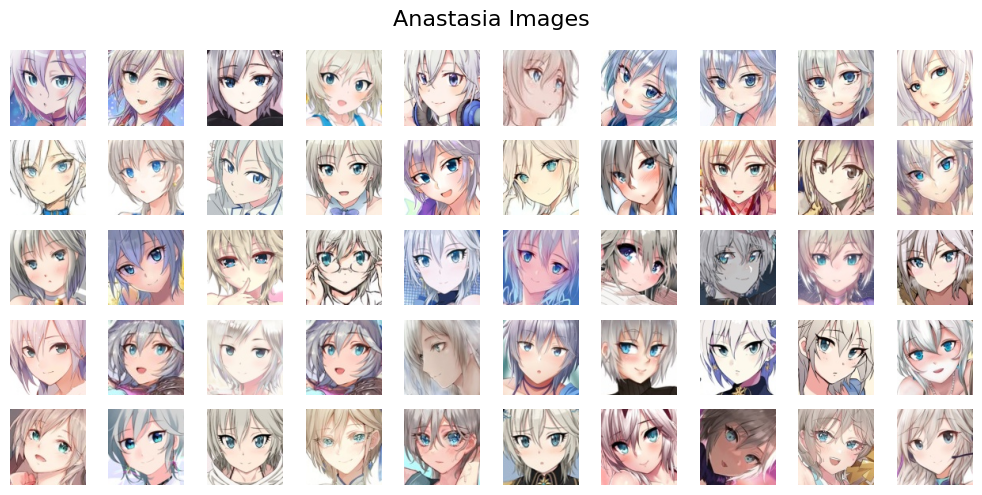

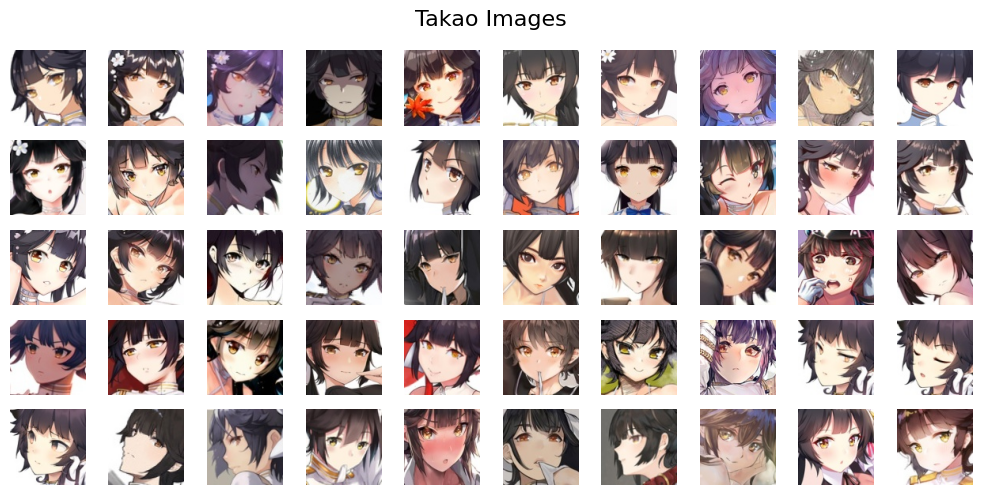

In [8]:
def plot_images(images, title):
    fig, axes = plt.subplots(5, 10, figsize=(10, 5))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Plot images from 'anastasia'
plot_images(images['anastasia'], 'Anastasia Images')

# Plot images from 'takao'
plot_images(images['takao'], 'Takao Images')

#### Create custom data class

In [9]:
class AnimeDataset(Dataset):
    def __init__(self, images, transform=None, classes=None):
        self.images = []
        self.labels = []
        self.transform = transform
        self.classes = classes
        
        for label, class_name in enumerate(self.classes):
            for img in images[class_name]:
                self.images.append(img)
                self.labels.append(label)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset
dataset = AnimeDataset(images, transform=transform, classes=['anastasia', 'takao'])


### Split the dataset into training and validation set

In [10]:
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Generate a list of indices for the entire dataset
indices = list(range(len(dataset)))

# Split the indices into training and validation sets
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=seed)

# Create samplers for training and validation sets
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Create DataLoader objects for training and validation sets
train_loader = DataLoader(dataset, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=20, sampler=val_sampler)

# Print the sizes of the training and validation sets
print("Train size:", len(train_indices))
print("Validation size:", len(val_indices))

Train size: 80
Validation size: 20


### Define the CNN model

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class AnimeCNN(nn.Module):
    def __init__(self):
        super(AnimeCNN, self).__init__()
        # Add padding=1 to maintain the border
        self.conv1 = nn.Conv2d(3, 32, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = AnimeCNN()

In [12]:
print(model)

AnimeCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [13]:
input_tensor = torch.randn(1, 3, 64, 64)

def print_size(module, input, output):
    print(f"{module.__class__.__name__} output size: {output.size()}")

# Register hooks
hooks = []
for layer in model.children():
    hook = layer.register_forward_hook(print_size)
    hooks.append(hook)

# Inspect output sizes
with torch.no_grad():
    output = model(input_tensor)
print("Final output size:", output.size())

# Remove hooks
for hook in hooks:
    hook.remove()

Conv2d output size: torch.Size([1, 32, 64, 64])
MaxPool2d output size: torch.Size([1, 32, 32, 32])
Conv2d output size: torch.Size([1, 64, 32, 32])
MaxPool2d output size: torch.Size([1, 64, 16, 16])
Linear output size: torch.Size([1, 128])
Linear output size: torch.Size([1, 2])
Final output size: torch.Size([1, 2])


### Define Loss and Optmizer

In [14]:
import torch.optim as optim

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Train the Model

In [15]:
import matplotlib.pyplot as plt
import torch

# Training loop
num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

print('Finished Training')



Epoch 1, Train Loss: 0.7333, Val Loss: 0.1828
Epoch 2, Train Loss: 0.1857, Val Loss: 0.0011
Epoch 3, Train Loss: 0.0471, Val Loss: 0.0005
Epoch 4, Train Loss: 0.0086, Val Loss: 0.0003
Epoch 5, Train Loss: 0.0009, Val Loss: 0.0002
Finished Training


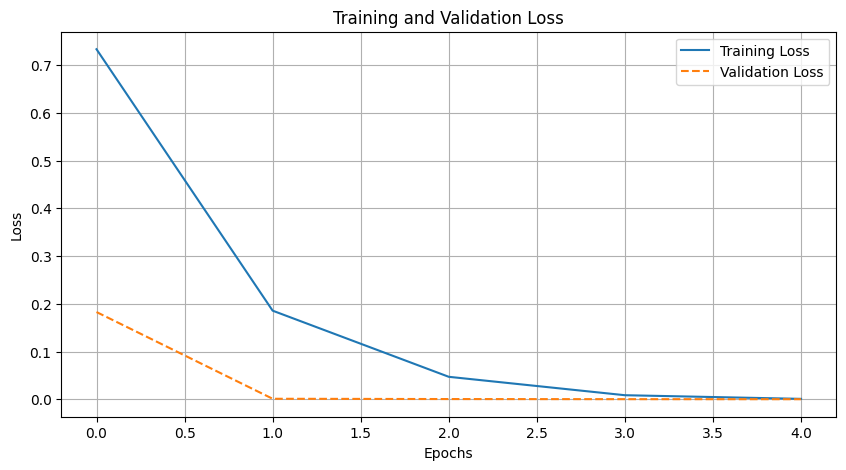

In [16]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()


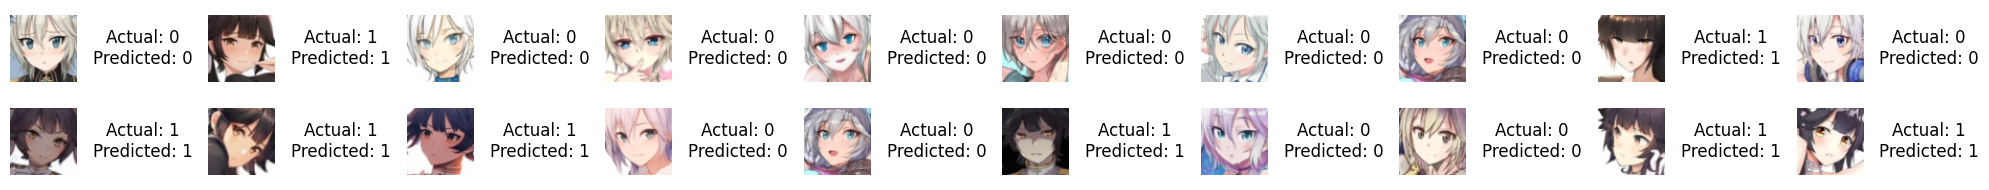

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to display an image
def imshow(img, ax):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))  # Transpose dimensions to match matplotlib's expected format
    ax.axis('off')

# Set model to evaluation mode
model.eval()

data_iter = iter(val_loader)
images, labels = next(data_iter)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Define the grid size
num_images = len(images)
num_cols = 10
num_rows = 2

fig, axs = plt.subplots(num_rows, num_cols * 2, figsize=(20, num_rows))

for idx in range(num_images):
    row = idx // num_cols
    col = (idx % num_cols) * 2
    
    # Plot the image
    imshow(images[idx].cpu(), axs[row, col])
    
    # Display actual and predicted labels
    axs[row, col + 1].text(0.5, 0.5, f"Actual: {labels[idx].item()}\nPredicted: {predicted[idx].item()}",
                           horizontalalignment='center', verticalalignment='center', fontsize=12)
    axs[row, col + 1].axis('off')

# Turn off any remaining empty subplots
for idx in range(num_images, num_rows * num_cols):
    row = idx // num_cols
    col = (idx % num_cols) * 2
    axs[row, col].axis('off')
    axs[row, col + 1].axis('off')

plt.tight_layout()
plt.show()

### Evaluate

In [18]:
correct = 0
total = 0

# Compute overall accuracy
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(f'correct: {correct}, total: {total}')

print(f'Validation Accuracy: {100 * correct / total:.2f}%')

correct: 20, total: 20
Validation Accuracy: 100.00%


### Change Activation function `leaky_relu`

In [19]:
class AnimeCNNModified(nn.Module):
    def __init__(self):
        super(AnimeCNNModified, self).__init__()
        # Add padding=1 to maintain the border
        self.conv1 = nn.Conv2d(3, 32, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)
        
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))  
        x = self.pool(F.leaky_relu(self.conv2(x)))  
        x = x.view(-1, 64 * 16 * 16)
        x = F.leaky_relu(self.fc1(x))  
        x = self.fc2(x)
        return x

Epoch 1, Train Loss: 0.3022, Val Loss: 0.0419
Epoch 2, Train Loss: 0.0891, Val Loss: 0.0156
Epoch 3, Train Loss: 0.0365, Val Loss: 0.0002
Epoch 4, Train Loss: 0.0196, Val Loss: 0.0016
Epoch 5, Train Loss: 0.0029, Val Loss: 0.0003
Epoch 6, Train Loss: 0.0003, Val Loss: 0.0001
Epoch 7, Train Loss: 0.0002, Val Loss: 0.0000
Epoch 8, Train Loss: 0.0002, Val Loss: 0.0000
Epoch 9, Train Loss: 0.0001, Val Loss: 0.0000
Epoch 10, Train Loss: 0.0001, Val Loss: 0.0000
Finished Training


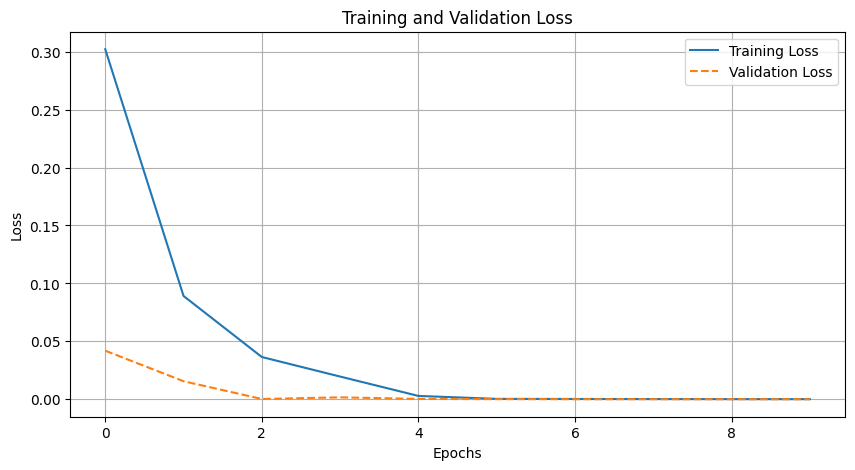

In [20]:
# Instantiate the model
model_new = AnimeCNN()

import torch.optim as optim

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_new.parameters(), lr=0.001)

import matplotlib.pyplot as plt
import torch

# Training loop
# TODO: Increase the number of epochs
num_epochs = 10 # Increase the number of epochs here
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model_new.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model_new(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    model_new.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = model_new(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

print('Finished Training')

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()